<a href="https://colab.research.google.com/github/Dusein/MachineLearningTask/blob/main/11thWeekTask/Deep_Learning_Model_For_Heart_Diasease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import itertools

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Ganti 'your_file_path' dengan path sebenarnya ke file CSV Anda di Google Drive
file_path = '/content/drive/My Drive/Dataset/heart.csv'

# Membaca file CSV ke dalam DataFrame
data = pd.read_csv(file_path)

# Menampilkan beberapa baris pertama dari DataFrame
print(data.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


In [6]:
# STEP 2: Preprocessing Data
# Memisahkan fitur (X) dan target (y)
X = data.iloc[:, :-1]  # Semua kolom kecuali kolom terakhir
y = data.iloc[:, -1]   # Kolom terakhir

# Standarisasi fitur untuk meningkatkan performa model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Membagi data menjadi data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Mengonversi data menjadi tensor PyTorch untuk pelatihan model
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


In [7]:
# STEP 3: Definisi Model MLP
# Membuat model MLP secara dinamis berdasarkan jumlah hidden layers dan neuron

class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(MLP, self).__init__()
        layers = []
        current_size = input_size

        # Menambahkan hidden layers secara dinamis
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(activation_fn())
            current_size = hidden_size

        # Menambahkan output layer
        layers.append(nn.Linear(current_size, 2))  # Binary classification (2 kelas)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [8]:
# STEP 4: Fungsi Pelatihan dan Evaluasi
def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Menghapus gradien sebelumnya
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Menghitung loss
        loss = criterion(outputs, labels)

        # Backward pass dan optimisasi
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

def evaluate_model(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            # Simpan prediksi dan label untuk menghitung akurasi
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return running_loss / len(test_loader), accuracy


In [9]:
# STEP 5: Eksperimen Parameter Hiper
# Definisi grid hyperparameter
hidden_layer_configs = [[4], [8], [16, 8], [32, 16, 8]]
activation_functions = [nn.ReLU, nn.Sigmoid, nn.Tanh]
epochs_list = [10, 25, 50]
learning_rates = [1, 0.1, 0.01, 0.001]
batch_sizes = [32, 64, 128]

dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []

for hidden_layers, activation_fn, num_epochs, lr, batch_size in itertools.product(
    hidden_layer_configs, activation_functions, epochs_list, learning_rates, batch_sizes):

    # Menyiapkan data loader
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

    # Inisialisasi model, fungsi loss, dan optimizer
    model = MLP(input_size=X_train.shape[1], hidden_layers=hidden_layers, activation_fn=activation_fn).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Melatih model
    for epoch in range(num_epochs):
        train_loss = train_model(model, criterion, optimizer, train_loader, device)

    # Evaluasi model
    test_loss, accuracy = evaluate_model(model, criterion, test_loader, device)

    # Menyimpan hasil
    results.append({
        'hidden_layers': hidden_layers,
        'activation_fn': activation_fn.__name__,
        'epochs': num_epochs,
        'learning_rate': lr,
        'batch_size': batch_size,
        'test_loss': test_loss,
        'accuracy': accuracy
    })

# Mengubah hasil menjadi DataFrame untuk analisis
results_df = pd.DataFrame(results)
results_df


,hidden_layers,activation_fn,epochs,learning_rate,batch_size,test_loss,accuracy
0,[4],ReLU,10,1.000,32,0.436206,0.785366
1,[4],ReLU,10,1.000,64,0.367740,0.800000
2,[4],ReLU,10,1.000,128,0.359238,0.814634
3,[4],ReLU,10,0.100,32,0.314664,0.878049
4,[4],ReLU,10,0.100,64,0.275126,0.912195
...,...,...,...,...,...,...,...
427,"[32, 16, 8]",Tanh,50,0.010,64,0.000827,1.000000
428,"[32, 16, 8]",Tanh,50,0.010,128,0.006246,1.000000
429,"[32, 16, 8]",Tanh,50,0.001,32,0.120648,0.980488
430,"[32, 16, 8]",Tanh,50,0.001,64,0.182812,0.936585


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['epochs'].plot(kind='hist', bins=20, title='epochs')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['learning_rate'].plot(kind='hist', bins=20, title='learning_rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['batch_size'].plot(kind='hist', bins=20, title='batch_size')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('activation_fn').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='epochs', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='epochs', y='learning_rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='learning_rate', y='batch_size', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='batch_size', y='test_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['epochs']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('activation_fn')):
  _plot_series(series, series_name, i)
  fig.legend(title='activation_fn', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('epochs')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['learning_rate']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('activation_fn')):
  _plot_series(series, series_name, i)
  fig.legend(title='activation_fn', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('learning_rate')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['batch_size']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('activation_fn')):
  _plot_series(series, series_name, i)
  fig.legend(title='activation_fn', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('batch_size')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['test_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('activation_fn')):
  _plot_series(series, series_name, i)
  fig.legend(title='activation_fn', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('test_loss')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['epochs'].plot(kind='line', figsize=(8, 4), title='epochs')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['learning_rate'].plot(kind='line', figsize=(8, 4), title='learning_rate')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['batch_size'].plot(kind='line', figsize=(8, 4), title='batch_size')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['activation_fn'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='activation_fn', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['activation_fn'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='epochs', y='activation_fn', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['activation_fn'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='learning_rate', y='activation_fn', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['activation_fn'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='batch_size', y='activation_fn', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [16]:
import pandas as pd

# Membaca file CSV yang diunggah
file_path = '/content/output.csv'
data = pd.read_csv(file_path)

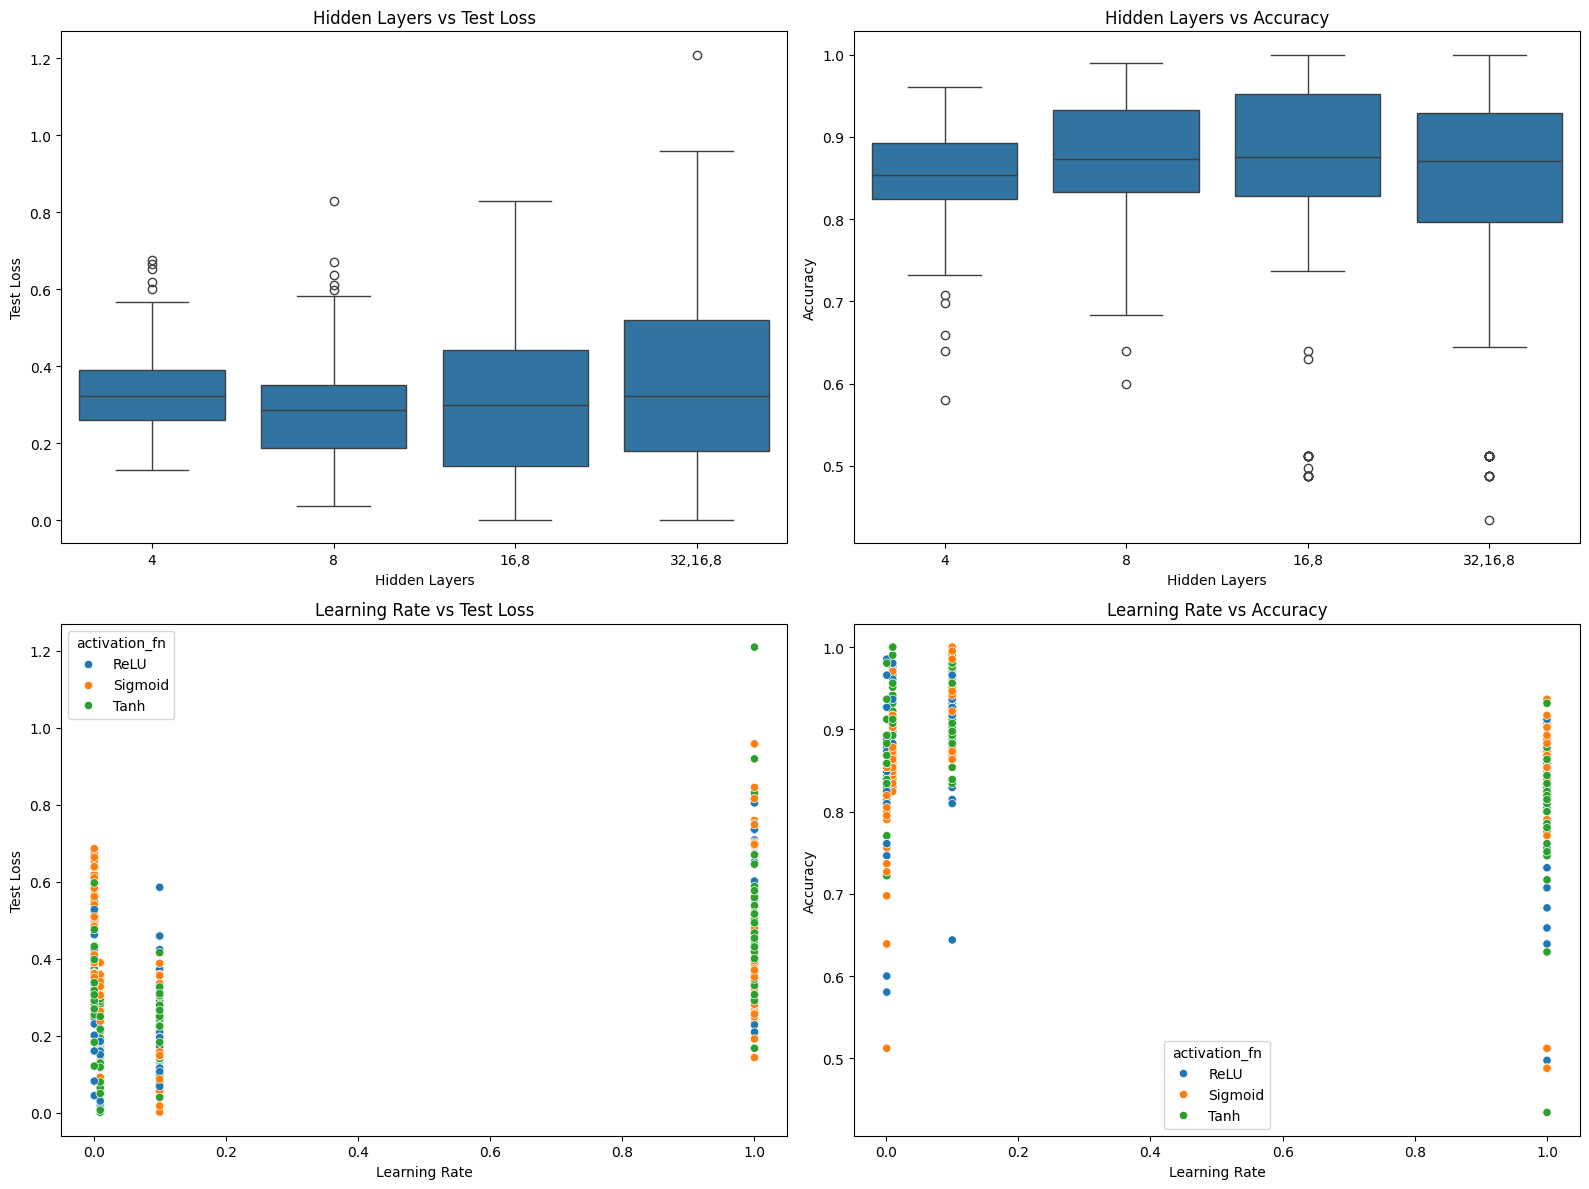

,index,hidden_layers,activation_fn,epochs,learning_rate,batch_size,test_loss,accuracy
count,432.000000,432,432,432.000000,432.00000,432.000000,432.000000,432.000000
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN
top,NaN,4,ReLU,NaN,NaN,NaN,NaN,NaN
freq,NaN,108,144,NaN,NaN,NaN,NaN,NaN
mean,215.500000,NaN,NaN,28.333333,0.27775,74.666667,0.327844,0.847245
std,124.851912,NaN,NaN,16.518288,0.41927,39.957286,0.194183,0.121008
min,0.000000,NaN,NaN,10.000000,0.00100,32.000000,0.000236,0.434146
25%,107.750000,NaN,NaN,10.000000,0.00775,32.000000,0.196401,0.824390
50%,215.500000,NaN,NaN,25.000000,0.05500,64.000000,0.308742,0.868293
75%,323.250000,NaN,NaN,50.000000,0.32500,128.000000,0.402033,0.921951


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Analisis deskriptif untuk setiap hyperparameter
summary = data.describe(include="all")

# Visualisasi hubungan antara hyperparameter dan hasil (loss dan accuracy)
plt.figure(figsize=(16, 12))

# Boxplot untuk hidden_layers vs test_loss
plt.subplot(2, 2, 1)
sns.boxplot(x="hidden_layers", y="test_loss", data=data)
plt.title("Hidden Layers vs Test Loss")
plt.xlabel("Hidden Layers")
plt.ylabel("Test Loss")

# Boxplot untuk hidden_layers vs accuracy
plt.subplot(2, 2, 2)
sns.boxplot(x="hidden_layers", y="accuracy", data=data)
plt.title("Hidden Layers vs Accuracy")
plt.xlabel("Hidden Layers")
plt.ylabel("Accuracy")

# Scatterplot untuk learning_rate vs test_loss
plt.subplot(2, 2, 3)
sns.scatterplot(x="learning_rate", y="test_loss", hue="activation_fn", data=data)
plt.title("Learning Rate vs Test Loss")
plt.xlabel("Learning Rate")
plt.ylabel("Test Loss")

# Scatterplot untuk learning_rate vs accuracy
plt.subplot(2, 2, 4)
sns.scatterplot(x="learning_rate", y="accuracy", hue="activation_fn", data=data)
plt.title("Learning Rate vs Accuracy")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

summary


In [10]:
import json
import csv

# Data JSON yang Anda miliki
data = [
    {"index":0,"hidden_layers":"4","activation_fn":"ReLU","epochs":10,"learning_rate":"1.0","batch_size":32,"test_loss":0.4362061023712158,"accuracy":"0.7853658536585366"},{"index":1,"hidden_layers":"4","activation_fn":"ReLU","epochs":10,"learning_rate":"1.0","batch_size":64,"test_loss":0.36773961782455444,"accuracy":"0.8"},{"index":2,"hidden_layers":"4","activation_fn":"ReLU","epochs":10,"learning_rate":"1.0","batch_size":128,"test_loss":0.3592381179332733,"accuracy":"0.8146341463414634"},{"index":3,"hidden_layers":"4","activation_fn":"ReLU","epochs":10,"learning_rate":"0.1","batch_size":32,"test_loss":0.31466428296906607,"accuracy":"0.8780487804878049"},{"index":4,"hidden_layers":"4","activation_fn":"ReLU","epochs":10,"learning_rate":"0.1","batch_size":64,"test_loss":0.27512630447745323,"accuracy":"0.9121951219512195"},{"index":5,"hidden_layers":"4","activation_fn":"ReLU","epochs":10,"learning_rate":"0.1","batch_size":128,"test_loss":0.3611897677183151,"accuracy":"0.8146341463414634"},{"index":6,"hidden_layers":"4","activation_fn":"ReLU","epochs":10,"learning_rate":"0.01","batch_size":32,"test_loss":0.315788345677512,"accuracy":"0.848780487804878"},{"index":7,"hidden_layers":"4","activation_fn":"ReLU","epochs":10,"learning_rate":"0.01","batch_size":64,"test_loss":0.2811522111296654,"accuracy":"0.8780487804878049"},{"index":8,"hidden_layers":"4","activation_fn":"ReLU","epochs":10,"learning_rate":"0.01","batch_size":128,"test_loss":0.3279160410165787,"accuracy":"0.8292682926829268"},{"index":9,"hidden_layers":"4","activation_fn":"ReLU","epochs":10,"learning_rate":"0.001","batch_size":32,"test_loss":0.41077825001307894,"accuracy":"0.8146341463414634"},{"index":10,"hidden_layers":"4","activation_fn":"ReLU","epochs":10,"learning_rate":"0.001","batch_size":64,"test_loss":0.5035482421517372,"accuracy":"0.7609756097560976"},{"index":11,"hidden_layers":"4","activation_fn":"ReLU","epochs":10,"learning_rate":"0.001","batch_size":128,"test_loss":0.6763562560081482,"accuracy":"0.5804878048780487"},{"index":12,"hidden_layers":"4","activation_fn":"ReLU","epochs":25,"learning_rate":"1.0","batch_size":32,"test_loss":0.6515014810221536,"accuracy":"0.6390243902439025"},{"index":13,"hidden_layers":"4","activation_fn":"ReLU","epochs":25,"learning_rate":"1.0","batch_size":64,"test_loss":0.39288076013326645,"accuracy":"0.8048780487804879"},{"index":14,"hidden_layers":"4","activation_fn":"ReLU","epochs":25,"learning_rate":"1.0","batch_size":128,"test_loss":0.4189506024122238,"accuracy":"0.7463414634146341"},{"index":15,"hidden_layers":"4","activation_fn":"ReLU","epochs":25,"learning_rate":"0.1","batch_size":32,"test_loss":0.35594423966748373,"accuracy":"0.8292682926829268"},{"index":16,"hidden_layers":"4","activation_fn":"ReLU","epochs":25,"learning_rate":"0.1","batch_size":64,"test_loss":0.31203334778547287,"accuracy":"0.8731707317073171"},{"index":17,"hidden_layers":"4","activation_fn":"ReLU","epochs":25,"learning_rate":"0.1","batch_size":128,"test_loss":0.24260886013507843,"accuracy":"0.9121951219512195"},{"index":18,"hidden_layers":"4","activation_fn":"ReLU","epochs":25,"learning_rate":"0.01","batch_size":32,"test_loss":0.3105052922453199,"accuracy":"0.848780487804878"},{"index":19,"hidden_layers":"4","activation_fn":"ReLU","epochs":25,"learning_rate":"0.01","batch_size":64,"test_loss":0.27289311215281487,"accuracy":"0.8780487804878049"},{"index":20,"hidden_layers":"4","activation_fn":"ReLU","epochs":25,"learning_rate":"0.01","batch_size":128,"test_loss":0.30909513682127,"accuracy":"0.8536585365853658"},{"index":21,"hidden_layers":"4","activation_fn":"ReLU","epochs":25,"learning_rate":"0.001","batch_size":32,"test_loss":0.3178424154009138,"accuracy":"0.8439024390243902"},{"index":22,"hidden_layers":"4","activation_fn":"ReLU","epochs":25,"learning_rate":"0.001","batch_size":64,"test_loss":0.40597738325595856,"accuracy":"0.8390243902439024"},{"index":23,"hidden_layers":"4","activation_fn":"ReLU","epochs":25,"learning_rate":"0.001","batch_size":128,"test_loss":0.49211783707141876,"accuracy":"0.7463414634146341"},{"index":24,"hidden_layers":"4","activation_fn":"ReLU","epochs":50,"learning_rate":"1.0","batch_size":32,"test_loss":0.601671176297324,"accuracy":"0.6585365853658537"},{"index":25,"hidden_layers":"4","activation_fn":"ReLU","epochs":50,"learning_rate":"1.0","batch_size":64,"test_loss":0.38622522354125977,"accuracy":"0.7073170731707317"},{"index":26,"hidden_layers":"4","activation_fn":"ReLU","epochs":50,"learning_rate":"1.0","batch_size":128,"test_loss":0.35716357827186584,"accuracy":"0.8585365853658536"},{"index":27,"hidden_layers":"4","activation_fn":"ReLU","epochs":50,"learning_rate":"0.1","batch_size":32,"test_loss":0.37207912121500286,"accuracy":"0.8829268292682927"},{"index":28,"hidden_layers":"4","activation_fn":"ReLU","epochs":50,"learning_rate":"0.1","batch_size":64,"test_loss":0.2708273343741894,"accuracy":"0.8731707317073171"},{"index":29,"hidden_layers":"4","activation_fn":"ReLU","epochs":50,"learning_rate":"0.1","batch_size":128,"test_loss":0.24359261244535446,"accuracy":"0.9073170731707317"},{"index":30,"hidden_layers":"4","activation_fn":"ReLU","epochs":50,"learning_rate":"0.01","batch_size":32,"test_loss":0.28732773874487194,"accuracy":"0.9073170731707317"},{"index":31,"hidden_layers":"4","activation_fn":"ReLU","epochs":50,"learning_rate":"0.01","batch_size":64,"test_loss":0.24202701076865196,"accuracy":"0.9024390243902439"},{"index":32,"hidden_layers":"4","activation_fn":"ReLU","epochs":50,"learning_rate":"0.01","batch_size":128,"test_loss":0.28344710916280746,"accuracy":"0.8536585365853658"},{"index":33,"hidden_layers":"4","activation_fn":"ReLU","epochs":50,"learning_rate":"0.001","batch_size":32,"test_loss":0.3241666832140514,"accuracy":"0.8292682926829268"},{"index":34,"hidden_layers":"4","activation_fn":"ReLU","epochs":50,"learning_rate":"0.001","batch_size":64,"test_loss":0.40172380208969116,"accuracy":"0.8731707317073171"},{"index":35,"hidden_layers":"4","activation_fn":"ReLU","epochs":50,"learning_rate":"0.001","batch_size":128,"test_loss":0.36971718072891235,"accuracy":"0.8439024390243902"},{"index":36,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":10,"learning_rate":"1.0","batch_size":32,"test_loss":0.37138038660798756,"accuracy":"0.8195121951219512"},{"index":37,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":10,"learning_rate":"1.0","batch_size":64,"test_loss":0.26605587266385555,"accuracy":"0.8682926829268293"},{"index":38,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":10,"learning_rate":"1.0","batch_size":128,"test_loss":0.2643119692802429,"accuracy":"0.8780487804878049"},{"index":39,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.1","batch_size":32,"test_loss":0.24182268870728357,"accuracy":"0.9024390243902439"},{"index":40,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.1","batch_size":64,"test_loss":0.26062170788645744,"accuracy":"0.8926829268292683"},{"index":41,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.1","batch_size":128,"test_loss":0.29001259058713913,"accuracy":"0.8780487804878049"},{"index":42,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.01","batch_size":32,"test_loss":0.3303102787051882,"accuracy":"0.848780487804878"},{"index":43,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.01","batch_size":64,"test_loss":0.34809647500514984,"accuracy":"0.8439024390243902"},{"index":44,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.01","batch_size":128,"test_loss":0.38936805725097656,"accuracy":"0.8390243902439024"},{"index":45,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.001","batch_size":32,"test_loss":0.5667540941919599,"accuracy":"0.8146341463414634"},{"index":46,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.001","batch_size":64,"test_loss":0.6188977956771851,"accuracy":"0.7560975609756098"},{"index":47,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.001","batch_size":128,"test_loss":0.6655951738357544,"accuracy":"0.697560975609756"},{"index":48,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":25,"learning_rate":"1.0","batch_size":32,"test_loss":0.3462317596588816,"accuracy":"0.8634146341463415"},{"index":49,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":25,"learning_rate":"1.0","batch_size":64,"test_loss":0.23420904949307442,"accuracy":"0.9073170731707317"},{"index":50,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":25,"learning_rate":"1.0","batch_size":128,"test_loss":0.249872125685215,"accuracy":"0.9024390243902439"},{"index":51,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.1","batch_size":32,"test_loss":0.1962907835841179,"accuracy":"0.926829268292683"},{"index":52,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.1","batch_size":64,"test_loss":0.23773232474923134,"accuracy":"0.8975609756097561"},{"index":53,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.1","batch_size":128,"test_loss":0.2096318155527115,"accuracy":"0.926829268292683"},{"index":54,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.01","batch_size":32,"test_loss":0.2904317591871534,"accuracy":"0.8780487804878049"},{"index":55,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.01","batch_size":64,"test_loss":0.29709863290190697,"accuracy":"0.8682926829268293"},{"index":56,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.01","batch_size":128,"test_loss":0.3269452005624771,"accuracy":"0.8536585365853658"},{"index":57,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.001","batch_size":32,"test_loss":0.4140717600073133,"accuracy":"0.8097560975609757"},{"index":58,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.001","batch_size":64,"test_loss":0.4995041713118553,"accuracy":"0.8341463414634146"},{"index":59,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.001","batch_size":128,"test_loss":0.565341979265213,"accuracy":"0.8390243902439024"},{"index":60,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":50,"learning_rate":"1.0","batch_size":32,"test_loss":0.289662387754236,"accuracy":"0.8731707317073171"},{"index":61,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":50,"learning_rate":"1.0","batch_size":64,"test_loss":0.32308288663625717,"accuracy":"0.848780487804878"},{"index":62,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":50,"learning_rate":"1.0","batch_size":128,"test_loss":0.24824468791484833,"accuracy":"0.9024390243902439"},{"index":63,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.1","batch_size":32,"test_loss":0.17337555012532643,"accuracy":"0.9219512195121952"},{"index":64,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.1","batch_size":64,"test_loss":0.130613146815449,"accuracy":"0.9512195121951219"},{"index":65,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.1","batch_size":128,"test_loss":0.1902296394109726,"accuracy":"0.9414634146341463"},{"index":66,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.01","batch_size":32,"test_loss":0.2480578316109521,"accuracy":"0.8926829268292683"},{"index":67,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.01","batch_size":64,"test_loss":0.25464823469519615,"accuracy":"0.8829268292682927"},{"index":68,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.01","batch_size":128,"test_loss":0.2828873097896576,"accuracy":"0.8780487804878049"},{"index":69,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.001","batch_size":32,"test_loss":0.34458636173180174,"accuracy":"0.8439024390243902"},{"index":70,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.001","batch_size":64,"test_loss":0.3821782320737839,"accuracy":"0.8048780487804879"},{"index":71,"hidden_layers":"4","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.001","batch_size":128,"test_loss":0.4875622093677521,"accuracy":"0.8097560975609757"},{"index":72,"hidden_layers":"4","activation_fn":"Tanh","epochs":10,"learning_rate":"1.0","batch_size":32,"test_loss":0.5143495329788753,"accuracy":"0.775609756097561"},{"index":73,"hidden_layers":"4","activation_fn":"Tanh","epochs":10,"learning_rate":"1.0","batch_size":64,"test_loss":0.46870172023773193,"accuracy":"0.8341463414634146"},{"index":74,"hidden_layers":"4","activation_fn":"Tanh","epochs":10,"learning_rate":"1.0","batch_size":128,"test_loss":0.4621158540248871,"accuracy":"0.8146341463414634"},{"index":75,"hidden_layers":"4","activation_fn":"Tanh","epochs":10,"learning_rate":"0.1","batch_size":32,"test_loss":0.2171072220163686,"accuracy":"0.9121951219512195"},{"index":76,"hidden_layers":"4","activation_fn":"Tanh","epochs":10,"learning_rate":"0.1","batch_size":64,"test_loss":0.2506198585033417,"accuracy":"0.9073170731707317"},{"index":77,"hidden_layers":"4","activation_fn":"Tanh","epochs":10,"learning_rate":"0.1","batch_size":128,"test_loss":0.2910945490002632,"accuracy":"0.8536585365853658"},{"index":78,"hidden_layers":"4","activation_fn":"Tanh","epochs":10,"learning_rate":"0.01","batch_size":32,"test_loss":0.2927013486623764,"accuracy":"0.8634146341463415"},{"index":79,"hidden_layers":"4","activation_fn":"Tanh","epochs":10,"learning_rate":"0.01","batch_size":64,"test_loss":0.3117561340332031,"accuracy":"0.8536585365853658"},{"index":80,"hidden_layers":"4","activation_fn":"Tanh","epochs":10,"learning_rate":"0.01","batch_size":128,"test_loss":0.322563037276268,"accuracy":"0.8390243902439024"},{"index":81,"hidden_layers":"4","activation_fn":"Tanh","epochs":10,"learning_rate":"0.001","batch_size":32,"test_loss":0.40937289595603943,"accuracy":"0.8292682926829268"},{"index":82,"hidden_layers":"4","activation_fn":"Tanh","epochs":10,"learning_rate":"0.001","batch_size":64,"test_loss":0.5106809958815575,"accuracy":"0.8"},{"index":83,"hidden_layers":"4","activation_fn":"Tanh","epochs":10,"learning_rate":"0.001","batch_size":128,"test_loss":0.5484605431556702,"accuracy":"0.7707317073170732"},{"index":84,"hidden_layers":"4","activation_fn":"Tanh","epochs":25,"learning_rate":"1.0","batch_size":32,"test_loss":0.4814735097544534,"accuracy":"0.7317073170731707"},{"index":85,"hidden_layers":"4","activation_fn":"Tanh","epochs":25,"learning_rate":"1.0","batch_size":64,"test_loss":0.3357998616993427,"accuracy":"0.8195121951219512"},{"index":86,"hidden_layers":"4","activation_fn":"Tanh","epochs":25,"learning_rate":"1.0","batch_size":128,"test_loss":0.3843143880367279,"accuracy":"0.8390243902439024"},{"index":87,"hidden_layers":"4","activation_fn":"Tanh","epochs":25,"learning_rate":"0.1","batch_size":32,"test_loss":0.23040473141840526,"accuracy":"0.9024390243902439"},{"index":88,"hidden_layers":"4","activation_fn":"Tanh","epochs":25,"learning_rate":"0.1","batch_size":64,"test_loss":0.16341915540397167,"accuracy":"0.926829268292683"},{"index":89,"hidden_layers":"4","activation_fn":"Tanh","epochs":25,"learning_rate":"0.1","batch_size":128,"test_loss":0.16479388624429703,"accuracy":"0.9512195121951219"},{"index":90,"hidden_layers":"4","activation_fn":"Tanh","epochs":25,"learning_rate":"0.01","batch_size":32,"test_loss":0.2550991582018988,"accuracy":"0.9024390243902439"},{"index":91,"hidden_layers":"4","activation_fn":"Tanh","epochs":25,"learning_rate":"0.01","batch_size":64,"test_loss":0.30676907673478127,"accuracy":"0.8536585365853658"},{"index":92,"hidden_layers":"4","activation_fn":"Tanh","epochs":25,"learning_rate":"0.01","batch_size":128,"test_loss":0.2726287692785263,"accuracy":"0.8926829268292683"},{"index":93,"hidden_layers":"4","activation_fn":"Tanh","epochs":25,"learning_rate":"0.001","batch_size":32,"test_loss":0.3375590443611145,"accuracy":"0.8439024390243902"},{"index":94,"hidden_layers":"4","activation_fn":"Tanh","epochs":25,"learning_rate":"0.001","batch_size":64,"test_loss":0.37382445484399796,"accuracy":"0.824390243902439"},{"index":95,"hidden_layers":"4","activation_fn":"Tanh","epochs":25,"learning_rate":"0.001","batch_size":128,"test_loss":0.43378593027591705,"accuracy":"0.824390243902439"},{"index":96,"hidden_layers":"4","activation_fn":"Tanh","epochs":50,"learning_rate":"1.0","batch_size":32,"test_loss":0.4401796076978956,"accuracy":"0.824390243902439"},{"index":97,"hidden_layers":"4","activation_fn":"Tanh","epochs":50,"learning_rate":"1.0","batch_size":64,"test_loss":0.37721575051546097,"accuracy":"0.8439024390243902"},{"index":98,"hidden_layers":"4","activation_fn":"Tanh","epochs":50,"learning_rate":"1.0","batch_size":128,"test_loss":0.33065277338027954,"accuracy":"0.8682926829268293"},{"index":99,"hidden_layers":"4","activation_fn":"Tanh","epochs":50,"learning_rate":"0.1","batch_size":32,"test_loss":0.2255351564713887,"accuracy":"0.8829268292682927"},{"index":100,"hidden_layers":"4","activation_fn":"Tanh","epochs":50,"learning_rate":"0.1","batch_size":64,"test_loss":0.21930253319442272,"accuracy":"0.9121951219512195"},{"index":101,"hidden_layers":"4","activation_fn":"Tanh","epochs":50,"learning_rate":"0.1","batch_size":128,"test_loss":0.15844878554344177,"accuracy":"0.9609756097560975"},{"index":102,"hidden_layers":"4","activation_fn":"Tanh","epochs":50,"learning_rate":"0.01","batch_size":32,"test_loss":0.17297221081597464,"accuracy":"0.9219512195121952"},{"index":103,"hidden_layers":"4","activation_fn":"Tanh","epochs":50,"learning_rate":"0.01","batch_size":64,"test_loss":0.18897772394120693,"accuracy":"0.9073170731707317"},{"index":104,"hidden_layers":"4","activation_fn":"Tanh","epochs":50,"learning_rate":"0.01","batch_size":128,"test_loss":0.25396639108657837,"accuracy":"0.8975609756097561"},{"index":105,"hidden_layers":"4","activation_fn":"Tanh","epochs":50,"learning_rate":"0.001","batch_size":32,"test_loss":0.31747910593237194,"accuracy":"0.8536585365853658"},{"index":106,"hidden_layers":"4","activation_fn":"Tanh","epochs":50,"learning_rate":"0.001","batch_size":64,"test_loss":0.32145849615335464,"accuracy":"0.8292682926829268"},{"index":107,"hidden_layers":"4","activation_fn":"Tanh","epochs":50,"learning_rate":"0.001","batch_size":128,"test_loss":0.3735272288322449,"accuracy":"0.8292682926829268"},{"index":108,"hidden_layers":"8","activation_fn":"ReLU","epochs":10,"learning_rate":"1.0","batch_size":32,"test_loss":0.3892775901726314,"accuracy":"0.8536585365853658"},{"index":109,"hidden_layers":"8","activation_fn":"ReLU","epochs":10,"learning_rate":"1.0","batch_size":64,"test_loss":0.3499956652522087,"accuracy":"0.7902439024390244"},{"index":110,"hidden_layers":"8","activation_fn":"ReLU","epochs":10,"learning_rate":"1.0","batch_size":128,"test_loss":0.34368036687374115,"accuracy":"0.8341463414634146"},{"index":111,"hidden_layers":"8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.1","batch_size":32,"test_loss":0.22353769625936235,"accuracy":"0.9073170731707317"},{"index":112,"hidden_layers":"8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.1","batch_size":64,"test_loss":0.24189171195030212,"accuracy":"0.8780487804878049"},{"index":113,"hidden_layers":"8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.1","batch_size":128,"test_loss":0.20782478898763657,"accuracy":"0.9317073170731708"},{"index":114,"hidden_layers":"8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.01","batch_size":32,"test_loss":0.2793097708906446,"accuracy":"0.8829268292682927"},{"index":115,"hidden_layers":"8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.01","batch_size":64,"test_loss":0.28007837012410164,"accuracy":"0.8585365853658536"},{"index":116,"hidden_layers":"8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.01","batch_size":128,"test_loss":0.29692938178777695,"accuracy":"0.8585365853658536"},{"index":117,"hidden_layers":"8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.001","batch_size":32,"test_loss":0.4029607389654432,"accuracy":"0.8097560975609757"},{"index":118,"hidden_layers":"8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.001","batch_size":64,"test_loss":0.46227622777223587,"accuracy":"0.8341463414634146"},{"index":119,"hidden_layers":"8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.001","batch_size":128,"test_loss":0.6368061304092407,"accuracy":"0.6"},{"index":120,"hidden_layers":"8","activation_fn":"ReLU","epochs":25,"learning_rate":"1.0","batch_size":32,"test_loss":0.5032161687101636,"accuracy":"0.7317073170731707"},{"index":121,"hidden_layers":"8","activation_fn":"ReLU","epochs":25,"learning_rate":"1.0","batch_size":64,"test_loss":0.8286429792642593,"accuracy":"0.6829268292682927"},{"index":122,"hidden_layers":"8","activation_fn":"ReLU","epochs":25,"learning_rate":"1.0","batch_size":128,"test_loss":0.2276732251048088,"accuracy":"0.8"},{"index":123,"hidden_layers":"8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.1","batch_size":32,"test_loss":0.12005294327225004,"accuracy":"0.9317073170731708"},{"index":124,"hidden_layers":"8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.1","batch_size":64,"test_loss":0.11558350455015898,"accuracy":"0.9463414634146341"},{"index":125,"hidden_layers":"8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.1","batch_size":128,"test_loss":0.12956547737121582,"accuracy":"0.9414634146341463"},{"index":126,"hidden_layers":"8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.01","batch_size":32,"test_loss":0.21497403936726706,"accuracy":"0.9414634146341463"},{"index":127,"hidden_layers":"8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.01","batch_size":64,"test_loss":0.21760955825448036,"accuracy":"0.9170731707317074"},{"index":128,"hidden_layers":"8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.01","batch_size":128,"test_loss":0.264518104493618,"accuracy":"0.8731707317073171"},{"index":129,"hidden_layers":"8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.001","batch_size":32,"test_loss":0.32406062313488554,"accuracy":"0.8195121951219512"},{"index":130,"hidden_layers":"8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.001","batch_size":64,"test_loss":0.32946813851594925,"accuracy":"0.8341463414634146"},{"index":131,"hidden_layers":"8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.001","batch_size":128,"test_loss":0.42413754761219025,"accuracy":"0.8146341463414634"},{"index":132,"hidden_layers":"8","activation_fn":"ReLU","epochs":50,"learning_rate":"1.0","batch_size":32,"test_loss":0.4361879527568817,"accuracy":"0.6390243902439025"},{"index":133,"hidden_layers":"8","activation_fn":"ReLU","epochs":50,"learning_rate":"1.0","batch_size":64,"test_loss":0.5550417304039001,"accuracy":"0.7560975609756098"},{"index":134,"hidden_layers":"8","activation_fn":"ReLU","epochs":50,"learning_rate":"1.0","batch_size":128,"test_loss":0.2091403231024742,"accuracy":"0.9121951219512195"},{"index":135,"hidden_layers":"8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.1","batch_size":32,"test_loss":0.16707698787961686,"accuracy":"0.9365853658536586"},{"index":136,"hidden_layers":"8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.1","batch_size":64,"test_loss":0.3011865373700857,"accuracy":"0.9073170731707317"},{"index":137,"hidden_layers":"8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.1","batch_size":128,"test_loss":0.1154477708041668,"accuracy":"0.9414634146341463"},{"index":138,"hidden_layers":"8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.01","batch_size":32,"test_loss":0.1293598445398467,"accuracy":"0.9512195121951219"},{"index":139,"hidden_layers":"8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.01","batch_size":64,"test_loss":0.16798632964491844,"accuracy":"0.9219512195121952"},{"index":140,"hidden_layers":"8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.01","batch_size":128,"test_loss":0.2439766228199005,"accuracy":"0.8975609756097561"},{"index":141,"hidden_layers":"8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.001","batch_size":32,"test_loss":0.28205755778721403,"accuracy":"0.8731707317073171"},{"index":142,"hidden_layers":"8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.001","batch_size":64,"test_loss":0.3016444593667984,"accuracy":"0.8731707317073171"},{"index":143,"hidden_layers":"8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.001","batch_size":128,"test_loss":0.32483792304992676,"accuracy":"0.8146341463414634"},{"index":144,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"1.0","batch_size":32,"test_loss":0.3532943832022803,"accuracy":"0.8195121951219512"},{"index":145,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"1.0","batch_size":64,"test_loss":0.2810008302330971,"accuracy":"0.9024390243902439"},{"index":146,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"1.0","batch_size":128,"test_loss":0.25804175436496735,"accuracy":"0.8878048780487805"},{"index":147,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.1","batch_size":32,"test_loss":0.13691127513136184,"accuracy":"0.9707317073170731"},{"index":148,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.1","batch_size":64,"test_loss":0.19643832370638847,"accuracy":"0.9170731707317074"},{"index":149,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.1","batch_size":128,"test_loss":0.26773668825626373,"accuracy":"0.8682926829268293"},{"index":150,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.01","batch_size":32,"test_loss":0.3237599560192653,"accuracy":"0.848780487804878"},{"index":151,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.01","batch_size":64,"test_loss":0.32548733428120613,"accuracy":"0.8341463414634146"},{"index":152,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.01","batch_size":128,"test_loss":0.34824687242507935,"accuracy":"0.824390243902439"},{"index":153,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.001","batch_size":32,"test_loss":0.483303964138031,"accuracy":"0.7902439024390244"},{"index":154,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.001","batch_size":64,"test_loss":0.5827457457780838,"accuracy":"0.7609756097560976"},{"index":155,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.001","batch_size":128,"test_loss":0.6100021004676819,"accuracy":"0.7902439024390244"},{"index":156,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"1.0","batch_size":32,"test_loss":0.3744094967842102,"accuracy":"0.8731707317073171"},{"index":157,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"1.0","batch_size":64,"test_loss":0.4283692166209221,"accuracy":"0.8536585365853658"},{"index":158,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"1.0","batch_size":128,"test_loss":0.1913527101278305,"accuracy":"0.9170731707317074"},{"index":159,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.1","batch_size":32,"test_loss":0.08683905484420913,"accuracy":"0.975609756097561"},{"index":160,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.1","batch_size":64,"test_loss":0.05438671912997961,"accuracy":"0.9804878048780488"},{"index":161,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.1","batch_size":128,"test_loss":0.1451631858944893,"accuracy":"0.9414634146341463"},{"index":162,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.01","batch_size":32,"test_loss":0.27003952860832214,"accuracy":"0.8926829268292683"},{"index":163,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.01","batch_size":64,"test_loss":0.2949080839753151,"accuracy":"0.848780487804878"},{"index":164,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.01","batch_size":128,"test_loss":0.32603973150253296,"accuracy":"0.8439024390243902"},{"index":165,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.001","batch_size":32,"test_loss":0.36307946273258757,"accuracy":"0.8292682926829268"},{"index":166,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.001","batch_size":64,"test_loss":0.409797728061676,"accuracy":"0.8097560975609757"},{"index":167,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.001","batch_size":128,"test_loss":0.5213607847690582,"accuracy":"0.8195121951219512"},{"index":168,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"1.0","batch_size":32,"test_loss":0.36783343127795626,"accuracy":"0.8682926829268293"},{"index":169,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"1.0","batch_size":64,"test_loss":0.2557164467871189,"accuracy":"0.8926829268292683"},{"index":170,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"1.0","batch_size":128,"test_loss":0.142942376434803,"accuracy":"0.9365853658536586"},{"index":171,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.1","batch_size":32,"test_loss":0.03743989113718271,"accuracy":"0.9902439024390244"},{"index":172,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.1","batch_size":64,"test_loss":0.06358164781704545,"accuracy":"0.9707317073170731"},{"index":173,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.1","batch_size":128,"test_loss":0.06165623851120472,"accuracy":"0.9804878048780488"},{"index":174,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.01","batch_size":32,"test_loss":0.17419071389096125,"accuracy":"0.9365853658536586"},{"index":175,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.01","batch_size":64,"test_loss":0.21329166367650032,"accuracy":"0.9121951219512195"},{"index":176,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.01","batch_size":128,"test_loss":0.2755194529891014,"accuracy":"0.8780487804878049"},{"index":177,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.001","batch_size":32,"test_loss":0.3400810552494867,"accuracy":"0.8341463414634146"},{"index":178,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.001","batch_size":64,"test_loss":0.347598597407341,"accuracy":"0.8341463414634146"},{"index":179,"hidden_layers":"8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.001","batch_size":128,"test_loss":0.3896413743495941,"accuracy":"0.824390243902439"},{"index":180,"hidden_layers":"8","activation_fn":"Tanh","epochs":10,"learning_rate":"1.0","batch_size":32,"test_loss":0.4479017917598997,"accuracy":"0.775609756097561"},{"index":181,"hidden_layers":"8","activation_fn":"Tanh","epochs":10,"learning_rate":"1.0","batch_size":64,"test_loss":0.4177072271704674,"accuracy":"0.824390243902439"},{"index":182,"hidden_layers":"8","activation_fn":"Tanh","epochs":10,"learning_rate":"1.0","batch_size":128,"test_loss":0.34801343083381653,"accuracy":"0.8536585365853658"},{"index":183,"hidden_layers":"8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.1","batch_size":32,"test_loss":0.18971786860908782,"accuracy":"0.9365853658536586"},{"index":184,"hidden_layers":"8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.1","batch_size":64,"test_loss":0.15422236174345016,"accuracy":"0.9365853658536586"},{"index":185,"hidden_layers":"8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.1","batch_size":128,"test_loss":0.2033122554421425,"accuracy":"0.9512195121951219"},{"index":186,"hidden_layers":"8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.01","batch_size":32,"test_loss":0.26473256945610046,"accuracy":"0.8780487804878049"},{"index":187,"hidden_layers":"8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.01","batch_size":64,"test_loss":0.28172609210014343,"accuracy":"0.8926829268292683"},{"index":188,"hidden_layers":"8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.01","batch_size":128,"test_loss":0.30936986207962036,"accuracy":"0.848780487804878"},{"index":189,"hidden_layers":"8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.001","batch_size":32,"test_loss":0.3496692989553724,"accuracy":"0.8390243902439024"},{"index":190,"hidden_layers":"8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.001","batch_size":64,"test_loss":0.4314882308244705,"accuracy":"0.824390243902439"},{"index":191,"hidden_layers":"8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.001","batch_size":128,"test_loss":0.5967990756034851,"accuracy":"0.7219512195121951"},{"index":192,"hidden_layers":"8","activation_fn":"Tanh","epochs":25,"learning_rate":"1.0","batch_size":32,"test_loss":0.4619866008205073,"accuracy":"0.8439024390243902"},{"index":193,"hidden_layers":"8","activation_fn":"Tanh","epochs":25,"learning_rate":"1.0","batch_size":64,"test_loss":0.33024669997394085,"accuracy":"0.8780487804878049"},{"index":194,"hidden_layers":"8","activation_fn":"Tanh","epochs":25,"learning_rate":"1.0","batch_size":128,"test_loss":0.29112252593040466,"accuracy":"0.8536585365853658"},{"index":195,"hidden_layers":"8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.1","batch_size":32,"test_loss":0.19816009460815362,"accuracy":"0.9414634146341463"},{"index":196,"hidden_layers":"8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.1","batch_size":64,"test_loss":0.11864737328141928,"accuracy":"0.9902439024390244"},{"index":197,"hidden_layers":"8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.1","batch_size":128,"test_loss":0.06332450918853283,"accuracy":"0.9902439024390244"},{"index":198,"hidden_layers":"8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.01","batch_size":32,"test_loss":0.18113338095801218,"accuracy":"0.9317073170731708"},{"index":199,"hidden_layers":"8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.01","batch_size":64,"test_loss":0.21103609539568424,"accuracy":"0.9219512195121952"},{"index":200,"hidden_layers":"8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.01","batch_size":128,"test_loss":0.28918810933828354,"accuracy":"0.8731707317073171"},{"index":201,"hidden_layers":"8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.001","batch_size":32,"test_loss":0.3323304291282381,"accuracy":"0.8390243902439024"},{"index":202,"hidden_layers":"8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.001","batch_size":64,"test_loss":0.3453103378415108,"accuracy":"0.8146341463414634"},{"index":203,"hidden_layers":"8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.001","batch_size":128,"test_loss":0.3896501958370209,"accuracy":"0.8146341463414634"},{"index":204,"hidden_layers":"8","activation_fn":"Tanh","epochs":50,"learning_rate":"1.0","batch_size":32,"test_loss":0.6695570136819567,"accuracy":"0.8341463414634146"},{"index":205,"hidden_layers":"8","activation_fn":"Tanh","epochs":50,"learning_rate":"1.0","batch_size":64,"test_loss":0.34675657749176025,"accuracy":"0.8292682926829268"},{"index":206,"hidden_layers":"8","activation_fn":"Tanh","epochs":50,"learning_rate":"1.0","batch_size":128,"test_loss":0.1670696660876274,"accuracy":"0.9317073170731708"},{"index":207,"hidden_layers":"8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.1","batch_size":32,"test_loss":0.09872098759348903,"accuracy":"0.9609756097560975"},{"index":208,"hidden_layers":"8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.1","batch_size":64,"test_loss":0.06770020024850965,"accuracy":"0.975609756097561"},{"index":209,"hidden_layers":"8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.1","batch_size":128,"test_loss":0.09639321267604828,"accuracy":"0.9853658536585366"},{"index":210,"hidden_layers":"8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.01","batch_size":32,"test_loss":0.08974488079547882,"accuracy":"0.9707317073170731"},{"index":211,"hidden_layers":"8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.01","batch_size":64,"test_loss":0.09149888949468732,"accuracy":"0.9707317073170731"},{"index":212,"hidden_layers":"8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.01","batch_size":128,"test_loss":0.1354193314909935,"accuracy":"0.975609756097561"},{"index":213,"hidden_layers":"8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.001","batch_size":32,"test_loss":0.3084480868918555,"accuracy":"0.8682926829268293"},{"index":214,"hidden_layers":"8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.001","batch_size":64,"test_loss":0.30087101459503174,"accuracy":"0.8536585365853658"},{"index":215,"hidden_layers":"8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.001","batch_size":128,"test_loss":0.33293262124061584,"accuracy":"0.8390243902439024"},{"index":216,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"1.0","batch_size":32,"test_loss":0.7005292092050824,"accuracy":"0.4878048780487805"},{"index":217,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"1.0","batch_size":64,"test_loss":0.6926587820053101,"accuracy":"0.4975609756097561"},{"index":218,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"1.0","batch_size":128,"test_loss":0.6897095739841461,"accuracy":"0.5121951219512195"},{"index":219,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.1","batch_size":32,"test_loss":0.20831318944692612,"accuracy":"0.9073170731707317"},{"index":220,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.1","batch_size":64,"test_loss":0.1884639784693718,"accuracy":"0.9219512195121952"},{"index":221,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.1","batch_size":128,"test_loss":0.14168507233262062,"accuracy":"0.9463414634146341"},{"index":222,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.01","batch_size":32,"test_loss":0.13501675426959991,"accuracy":"0.9365853658536586"},{"index":223,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.01","batch_size":64,"test_loss":0.15985929127782583,"accuracy":"0.9560975609756097"},{"index":224,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.01","batch_size":128,"test_loss":0.257830448448658,"accuracy":"0.8829268292682927"},{"index":225,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.001","batch_size":32,"test_loss":0.33151913966451374,"accuracy":"0.8341463414634146"},{"index":226,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.001","batch_size":64,"test_loss":0.36309734731912613,"accuracy":"0.8195121951219512"},{"index":227,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.001","batch_size":128,"test_loss":0.529346227645874,"accuracy":"0.7609756097560976"},{"index":228,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"1.0","batch_size":32,"test_loss":0.6930785860334124,"accuracy":"0.5121951219512195"},{"index":229,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"1.0","batch_size":64,"test_loss":0.7032124996185303,"accuracy":"0.5121951219512195"},{"index":230,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"1.0","batch_size":128,"test_loss":0.6979008316993713,"accuracy":"0.4878048780487805"},{"index":231,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.1","batch_size":32,"test_loss":0.11439578075494085,"accuracy":"0.9560975609756097"},{"index":232,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.1","batch_size":64,"test_loss":0.10803922079503536,"accuracy":"0.9609756097560975"},{"index":233,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.1","batch_size":128,"test_loss":0.07620175369083881,"accuracy":"0.9707317073170731"},{"index":234,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.01","batch_size":32,"test_loss":0.045236002653837204,"accuracy":"0.9804878048780488"},{"index":235,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.01","batch_size":64,"test_loss":0.08006993774324656,"accuracy":"0.9658536585365853"},{"index":236,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.01","batch_size":128,"test_loss":0.12965217232704163,"accuracy":"0.9707317073170731"},{"index":237,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.001","batch_size":32,"test_loss":0.25267150146620615,"accuracy":"0.8926829268292683"},{"index":238,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.001","batch_size":64,"test_loss":0.2821502760052681,"accuracy":"0.848780487804878"},{"index":239,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.001","batch_size":128,"test_loss":0.33350802958011627,"accuracy":"0.8682926829268293"},{"index":240,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"1.0","batch_size":32,"test_loss":0.7086510147367205,"accuracy":"0.5121951219512195"},{"index":241,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"1.0","batch_size":64,"test_loss":0.6992790102958679,"accuracy":"0.5121951219512195"},{"index":242,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"1.0","batch_size":128,"test_loss":0.3635866641998291,"accuracy":"0.8341463414634146"},{"index":243,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.1","batch_size":32,"test_loss":0.31170925285135,"accuracy":"0.8780487804878049"},{"index":244,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.1","batch_size":64,"test_loss":0.11566684395074844,"accuracy":"0.9317073170731708"},{"index":245,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.1","batch_size":128,"test_loss":0.06836435943841934,"accuracy":"0.9463414634146341"},{"index":246,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.01","batch_size":32,"test_loss":0.01715531007253698,"accuracy":"0.9902439024390244"},{"index":247,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.01","batch_size":64,"test_loss":0.0021993559203110635,"accuracy":"1.0"},{"index":248,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.01","batch_size":128,"test_loss":0.010157683631405234,"accuracy":"1.0"},{"index":249,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.001","batch_size":32,"test_loss":0.244175951395716,"accuracy":"0.8878048780487805"},{"index":250,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.001","batch_size":64,"test_loss":0.24750997126102448,"accuracy":"0.8780487804878049"},{"index":251,"hidden_layers":"16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.001","batch_size":128,"test_loss":0.30013318359851837,"accuracy":"0.8731707317073171"},{"index":252,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"1.0","batch_size":32,"test_loss":0.6978779009410313,"accuracy":"0.4878048780487805"},{"index":253,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"1.0","batch_size":64,"test_loss":0.7594528496265411,"accuracy":"0.4878048780487805"},{"index":254,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"1.0","batch_size":128,"test_loss":0.7465018332004547,"accuracy":"0.5121951219512195"},{"index":255,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.1","batch_size":32,"test_loss":0.1820781390581812,"accuracy":"0.9365853658536586"},{"index":256,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.1","batch_size":64,"test_loss":0.1577527690678835,"accuracy":"0.9609756097560975"},{"index":257,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.1","batch_size":128,"test_loss":0.2436181902885437,"accuracy":"0.9121951219512195"},{"index":258,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.01","batch_size":32,"test_loss":0.34752111775534494,"accuracy":"0.8585365853658536"},{"index":259,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.01","batch_size":64,"test_loss":0.3316592425107956,"accuracy":"0.8536585365853658"},{"index":260,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.01","batch_size":128,"test_loss":0.3281508833169937,"accuracy":"0.8536585365853658"},{"index":261,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.001","batch_size":32,"test_loss":0.5405367357390267,"accuracy":"0.8"},{"index":262,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.001","batch_size":64,"test_loss":0.6531011015176773,"accuracy":"0.7365853658536585"},{"index":263,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.001","batch_size":128,"test_loss":0.6723855435848236,"accuracy":"0.6390243902439025"},{"index":264,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"1.0","batch_size":32,"test_loss":0.7349564603396824,"accuracy":"0.4878048780487805"},{"index":265,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"1.0","batch_size":64,"test_loss":0.5618079900741577,"accuracy":"0.7707317073170732"},{"index":266,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"1.0","batch_size":128,"test_loss":0.47774477303028107,"accuracy":"0.7902439024390244"},{"index":267,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.1","batch_size":32,"test_loss":0.05524574782300208,"accuracy":"0.9707317073170731"},{"index":268,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.1","batch_size":64,"test_loss":0.05564012913964689,"accuracy":"0.9853658536585366"},{"index":269,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.1","batch_size":128,"test_loss":0.09880669042468071,"accuracy":"0.9804878048780488"},{"index":270,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.01","batch_size":32,"test_loss":0.24000021070241928,"accuracy":"0.9121951219512195"},{"index":271,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.01","batch_size":64,"test_loss":0.2634083740413189,"accuracy":"0.9024390243902439"},{"index":272,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.01","batch_size":128,"test_loss":0.30830324441194534,"accuracy":"0.848780487804878"},{"index":273,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.001","batch_size":32,"test_loss":0.3563120173556464,"accuracy":"0.8341463414634146"},{"index":274,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.001","batch_size":64,"test_loss":0.3895892798900604,"accuracy":"0.8292682926829268"},{"index":275,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.001","batch_size":128,"test_loss":0.5610861480236053,"accuracy":"0.7951219512195122"},{"index":276,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"1.0","batch_size":32,"test_loss":0.39456167604242054,"accuracy":"0.8390243902439024"},{"index":277,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"1.0","batch_size":64,"test_loss":0.8036736994981766,"accuracy":"0.5121951219512195"},{"index":278,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"1.0","batch_size":128,"test_loss":0.35217683017253876,"accuracy":"0.8829268292682927"},{"index":279,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.1","batch_size":32,"test_loss":0.0011908540992798017,"accuracy":"1.0"},{"index":280,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.1","batch_size":64,"test_loss":0.1440407233312726,"accuracy":"0.9512195121951219"},{"index":281,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.1","batch_size":128,"test_loss":0.017179278889670968,"accuracy":"0.9951219512195122"},{"index":282,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.01","batch_size":32,"test_loss":0.09170196098940712,"accuracy":"0.9902439024390244"},{"index":283,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.01","batch_size":64,"test_loss":0.14445955585688353,"accuracy":"0.9707317073170731"},{"index":284,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.01","batch_size":128,"test_loss":0.2467593103647232,"accuracy":"0.9073170731707317"},{"index":285,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.001","batch_size":32,"test_loss":0.34062083065509796,"accuracy":"0.8536585365853658"},{"index":286,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.001","batch_size":64,"test_loss":0.3486499637365341,"accuracy":"0.8536585365853658"},{"index":287,"hidden_layers":"16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.001","batch_size":128,"test_loss":0.3591868728399277,"accuracy":"0.8292682926829268"},{"index":288,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"1.0","batch_size":32,"test_loss":0.6453576258250645,"accuracy":"0.7804878048780488"},{"index":289,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"1.0","batch_size":64,"test_loss":0.5381328538060188,"accuracy":"0.8634146341463415"},{"index":290,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"1.0","batch_size":128,"test_loss":0.4002556651830673,"accuracy":"0.8097560975609757"},{"index":291,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.1","batch_size":32,"test_loss":0.24136970617941447,"accuracy":"0.8878048780487805"},{"index":292,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.1","batch_size":64,"test_loss":0.14062825497239828,"accuracy":"0.9658536585365853"},{"index":293,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.1","batch_size":128,"test_loss":0.2257581204175949,"accuracy":"0.926829268292683"},{"index":294,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.01","batch_size":32,"test_loss":0.19350202594484603,"accuracy":"0.9414634146341463"},{"index":295,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.01","batch_size":64,"test_loss":0.24808726087212563,"accuracy":"0.9024390243902439"},{"index":296,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.01","batch_size":128,"test_loss":0.2958335652947426,"accuracy":"0.8634146341463415"},{"index":297,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.001","batch_size":32,"test_loss":0.3424324712582997,"accuracy":"0.8292682926829268"},{"index":298,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.001","batch_size":64,"test_loss":0.359244741499424,"accuracy":"0.8390243902439024"},{"index":299,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.001","batch_size":128,"test_loss":0.4757423847913742,"accuracy":"0.848780487804878"},{"index":300,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"1.0","batch_size":32,"test_loss":0.8300170728138515,"accuracy":"0.6292682926829268"},{"index":301,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"1.0","batch_size":64,"test_loss":0.4999631494283676,"accuracy":"0.8146341463414634"},{"index":302,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"1.0","batch_size":128,"test_loss":0.43067117035388947,"accuracy":"0.8341463414634146"},{"index":303,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.1","batch_size":32,"test_loss":0.19607667305639812,"accuracy":"0.9121951219512195"},{"index":304,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.1","batch_size":64,"test_loss":0.09593652654439211,"accuracy":"0.975609756097561"},{"index":305,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.1","batch_size":128,"test_loss":0.07846078276634216,"accuracy":"0.9804878048780488"},{"index":306,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.01","batch_size":32,"test_loss":0.04741219963346209,"accuracy":"0.9902439024390244"},{"index":307,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.01","batch_size":64,"test_loss":0.06440865900367498,"accuracy":"0.9902439024390244"},{"index":308,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.01","batch_size":128,"test_loss":0.18401214480400085,"accuracy":"0.9170731707317074"},{"index":309,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.001","batch_size":32,"test_loss":0.3179321714809963,"accuracy":"0.8536585365853658"},{"index":310,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.001","batch_size":64,"test_loss":0.32116635888814926,"accuracy":"0.848780487804878"},{"index":311,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.001","batch_size":128,"test_loss":0.3411952555179596,"accuracy":"0.8341463414634146"},{"index":312,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"1.0","batch_size":32,"test_loss":0.5877345012766975,"accuracy":"0.824390243902439"},{"index":313,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"1.0","batch_size":64,"test_loss":0.5190941262990236,"accuracy":"0.8195121951219512"},{"index":314,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"1.0","batch_size":128,"test_loss":0.30645203590393066,"accuracy":"0.8439024390243902"},{"index":315,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.1","batch_size":32,"test_loss":0.16331628390720912,"accuracy":"0.9121951219512195"},{"index":316,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.1","batch_size":64,"test_loss":0.1692999079823494,"accuracy":"0.9414634146341463"},{"index":317,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.1","batch_size":128,"test_loss":0.03959503211081028,"accuracy":"0.9804878048780488"},{"index":318,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.01","batch_size":32,"test_loss":0.0006368025206029415,"accuracy":"1.0"},{"index":319,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.01","batch_size":64,"test_loss":0.003337377856951207,"accuracy":"1.0"},{"index":320,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.01","batch_size":128,"test_loss":0.07922440581023693,"accuracy":"0.9902439024390244"},{"index":321,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.001","batch_size":32,"test_loss":0.2540909839527948,"accuracy":"0.9121951219512195"},{"index":322,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.001","batch_size":64,"test_loss":0.30124369636178017,"accuracy":"0.8536585365853658"},{"index":323,"hidden_layers":"16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.001","batch_size":128,"test_loss":0.31488656997680664,"accuracy":"0.8585365853658536"},{"index":324,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"1.0","batch_size":32,"test_loss":0.7507068685122898,"accuracy":"0.5121951219512195"},{"index":325,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"1.0","batch_size":64,"test_loss":0.7344001084566116,"accuracy":"0.5121951219512195"},{"index":326,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"1.0","batch_size":128,"test_loss":0.6947451531887054,"accuracy":"0.5121951219512195"},{"index":327,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.1","batch_size":32,"test_loss":0.4588980781180518,"accuracy":"0.8829268292682927"},{"index":328,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.1","batch_size":64,"test_loss":0.1719611268490553,"accuracy":"0.9024390243902439"},{"index":329,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.1","batch_size":128,"test_loss":0.15591587498784065,"accuracy":"0.9170731707317074"},{"index":330,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.01","batch_size":32,"test_loss":0.15040584866489684,"accuracy":"0.9609756097560975"},{"index":331,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.01","batch_size":64,"test_loss":0.11644684802740812,"accuracy":"0.9560975609756097"},{"index":332,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.01","batch_size":128,"test_loss":0.18516376987099648,"accuracy":"0.9365853658536586"},{"index":333,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.001","batch_size":32,"test_loss":0.2704649269580841,"accuracy":"0.8926829268292683"},{"index":334,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.001","batch_size":64,"test_loss":0.3103495463728905,"accuracy":"0.824390243902439"},{"index":335,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":10,"learning_rate":"0.001","batch_size":128,"test_loss":0.5274961888790131,"accuracy":"0.8097560975609757"},{"index":336,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"1.0","batch_size":32,"test_loss":0.6934649348258972,"accuracy":"0.5121951219512195"},{"index":337,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"1.0","batch_size":64,"test_loss":0.6925479918718338,"accuracy":"0.5121951219512195"},{"index":338,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"1.0","batch_size":128,"test_loss":0.7029946744441986,"accuracy":"0.5121951219512195"},{"index":339,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.1","batch_size":32,"test_loss":0.585463115147182,"accuracy":"0.6439024390243903"},{"index":340,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.1","batch_size":64,"test_loss":0.14692462980747223,"accuracy":"0.926829268292683"},{"index":341,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.1","batch_size":128,"test_loss":0.10634885355830193,"accuracy":"0.9365853658536586"},{"index":342,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.01","batch_size":32,"test_loss":0.0030870015907566994,"accuracy":"1.0"},{"index":343,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.01","batch_size":64,"test_loss":0.0012615989398909733,"accuracy":"1.0"},{"index":344,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.01","batch_size":128,"test_loss":0.02997578587383032,"accuracy":"0.9804878048780488"},{"index":345,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.001","batch_size":32,"test_loss":0.15999056292431696,"accuracy":"0.926829268292683"},{"index":346,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.001","batch_size":64,"test_loss":0.23028234764933586,"accuracy":"0.8926829268292683"},{"index":347,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":25,"learning_rate":"0.001","batch_size":128,"test_loss":0.2925923988223076,"accuracy":"0.848780487804878"},{"index":348,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"1.0","batch_size":32,"test_loss":0.8047974194799151,"accuracy":"0.5121951219512195"},{"index":349,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"1.0","batch_size":64,"test_loss":0.7364456951618195,"accuracy":"0.5121951219512195"},{"index":350,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"1.0","batch_size":128,"test_loss":0.6991939544677734,"accuracy":"0.5121951219512195"},{"index":351,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.1","batch_size":32,"test_loss":0.42359218427113127,"accuracy":"0.8097560975609757"},{"index":352,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.1","batch_size":64,"test_loss":0.19507337361574173,"accuracy":"0.9365853658536586"},{"index":353,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.1","batch_size":128,"test_loss":0.06805631890892982,"accuracy":"0.9658536585365853"},{"index":354,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.01","batch_size":32,"test_loss":0.0017821489599165424,"accuracy":"1.0"},{"index":355,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.01","batch_size":64,"test_loss":0.0008097096433630213,"accuracy":"1.0"},{"index":356,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.01","batch_size":128,"test_loss":0.0005095553788123652,"accuracy":"1.0"},{"index":357,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.001","batch_size":32,"test_loss":0.04381531237491539,"accuracy":"0.9853658536585366"},{"index":358,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.001","batch_size":64,"test_loss":0.08164412900805473,"accuracy":"0.9658536585365853"},{"index":359,"hidden_layers":"32,16,8","activation_fn":"ReLU","epochs":50,"learning_rate":"0.001","batch_size":128,"test_loss":0.20106985419988632,"accuracy":"0.8878048780487805"},{"index":360,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"1.0","batch_size":32,"test_loss":0.6927760584013802,"accuracy":"0.5121951219512195"},{"index":361,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"1.0","batch_size":64,"test_loss":0.9582413882017136,"accuracy":"0.4878048780487805"},{"index":362,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"1.0","batch_size":128,"test_loss":0.3702017068862915,"accuracy":"0.8536585365853658"},{"index":363,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.1","batch_size":32,"test_loss":0.3879326581954956,"accuracy":"0.8682926829268293"},{"index":364,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.1","batch_size":64,"test_loss":0.35890092328190804,"accuracy":"0.8731707317073171"},{"index":365,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.1","batch_size":128,"test_loss":0.3588726818561554,"accuracy":"0.8634146341463415"},{"index":366,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.01","batch_size":32,"test_loss":0.35835197142192293,"accuracy":"0.8682926829268293"},{"index":367,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.01","batch_size":64,"test_loss":0.36051540449261665,"accuracy":"0.8731707317073171"},{"index":368,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.01","batch_size":128,"test_loss":0.3581075817346573,"accuracy":"0.8536585365853658"},{"index":369,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.001","batch_size":32,"test_loss":0.5084468466894967,"accuracy":"0.8048780487804879"},{"index":370,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.001","batch_size":64,"test_loss":0.6635109931230545,"accuracy":"0.7268292682926829"},{"index":371,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":10,"learning_rate":"0.001","batch_size":128,"test_loss":0.6861473917961121,"accuracy":"0.5121951219512195"},{"index":372,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"1.0","batch_size":32,"test_loss":0.694555231503078,"accuracy":"0.4878048780487805"},{"index":373,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"1.0","batch_size":64,"test_loss":0.8451775312423706,"accuracy":"0.4878048780487805"},{"index":374,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"1.0","batch_size":128,"test_loss":0.7004416286945343,"accuracy":"0.5121951219512195"},{"index":375,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.1","batch_size":32,"test_loss":0.26337680965662,"accuracy":"0.9219512195121952"},{"index":376,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.1","batch_size":64,"test_loss":0.15784357115626335,"accuracy":"0.9414634146341463"},{"index":377,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.1","batch_size":128,"test_loss":0.33555927127599716,"accuracy":"0.8780487804878049"},{"index":378,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.01","batch_size":32,"test_loss":0.23721366269247873,"accuracy":"0.9170731707317074"},{"index":379,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.01","batch_size":64,"test_loss":0.34056778624653816,"accuracy":"0.8780487804878049"},{"index":380,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.01","batch_size":128,"test_loss":0.3276643678545952,"accuracy":"0.8634146341463415"},{"index":381,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.001","batch_size":32,"test_loss":0.3616774209908077,"accuracy":"0.8536585365853658"},{"index":382,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.001","batch_size":64,"test_loss":0.38965194672346115,"accuracy":"0.8536585365853658"},{"index":383,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":25,"learning_rate":"0.001","batch_size":128,"test_loss":0.6389890611171722,"accuracy":"0.8195121951219512"},{"index":384,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"1.0","batch_size":32,"test_loss":0.6969659669058663,"accuracy":"0.4878048780487805"},{"index":385,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"1.0","batch_size":64,"test_loss":0.7482443600893021,"accuracy":"0.5121951219512195"},{"index":386,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"1.0","batch_size":128,"test_loss":0.8163037896156311,"accuracy":"0.4878048780487805"},{"index":387,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.1","batch_size":32,"test_loss":0.08706313125523073,"accuracy":"0.9853658536585366"},{"index":388,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.1","batch_size":64,"test_loss":0.1485488023608923,"accuracy":"0.9463414634146341"},{"index":389,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.1","batch_size":128,"test_loss":0.35584546625614166,"accuracy":"0.8731707317073171"},{"index":390,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.01","batch_size":32,"test_loss":0.30523131787776947,"accuracy":"0.9024390243902439"},{"index":391,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.01","batch_size":64,"test_loss":0.30603688955307007,"accuracy":"0.9024390243902439"},{"index":392,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.01","batch_size":128,"test_loss":0.3051125779747963,"accuracy":"0.9024390243902439"},{"index":393,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.001","batch_size":32,"test_loss":0.36097327939101626,"accuracy":"0.8682926829268293"},{"index":394,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.001","batch_size":64,"test_loss":0.3336368128657341,"accuracy":"0.8536585365853658"},{"index":395,"hidden_layers":"32,16,8","activation_fn":"Sigmoid","epochs":50,"learning_rate":"0.001","batch_size":128,"test_loss":0.35122060775756836,"accuracy":"0.8536585365853658"},{"index":396,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"1.0","batch_size":32,"test_loss":0.9193436077662877,"accuracy":"0.7463414634146341"},{"index":397,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"1.0","batch_size":64,"test_loss":0.46669313311576843,"accuracy":"0.8146341463414634"},{"index":398,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"1.0","batch_size":128,"test_loss":0.5591469705104828,"accuracy":"0.7853658536585366"},{"index":399,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.1","batch_size":32,"test_loss":0.27882544696331024,"accuracy":"0.9024390243902439"},{"index":400,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.1","batch_size":64,"test_loss":0.3264719918370247,"accuracy":"0.8390243902439024"},{"index":401,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.1","batch_size":128,"test_loss":0.3040824308991432,"accuracy":"0.8341463414634146"},{"index":402,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.01","batch_size":32,"test_loss":0.128685398293393,"accuracy":"0.9512195121951219"},{"index":403,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.01","batch_size":64,"test_loss":0.21654337085783482,"accuracy":"0.9073170731707317"},{"index":404,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.01","batch_size":128,"test_loss":0.24960432201623917,"accuracy":"0.9121951219512195"},{"index":405,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.001","batch_size":32,"test_loss":0.317152168069567,"accuracy":"0.8585365853658536"},{"index":406,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.001","batch_size":64,"test_loss":0.33768822252750397,"accuracy":"0.8682926829268293"},{"index":407,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":10,"learning_rate":"0.001","batch_size":128,"test_loss":0.3975757509469986,"accuracy":"0.8341463414634146"},{"index":408,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"1.0","batch_size":32,"test_loss":1.2097714969090052,"accuracy":"0.43414634146341463"},{"index":409,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"1.0","batch_size":64,"test_loss":0.5765828266739845,"accuracy":"0.751219512195122"},{"index":410,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"1.0","batch_size":128,"test_loss":0.5160344988107681,"accuracy":"0.7170731707317073"},{"index":411,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.1","batch_size":32,"test_loss":0.25012325389044626,"accuracy":"0.8829268292682927"},{"index":412,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.1","batch_size":64,"test_loss":0.22450033761560917,"accuracy":"0.9073170731707317"},{"index":413,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.1","batch_size":128,"test_loss":0.1827843338251114,"accuracy":"0.9560975609756097"},{"index":414,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.01","batch_size":32,"test_loss":0.0026444153377919327,"accuracy":"1.0"},{"index":415,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.01","batch_size":64,"test_loss":0.0495330918347463,"accuracy":"0.9902439024390244"},{"index":416,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.01","batch_size":128,"test_loss":0.11796539463102818,"accuracy":"0.9560975609756097"},{"index":417,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.001","batch_size":32,"test_loss":0.28227232822350096,"accuracy":"0.8829268292682927"},{"index":418,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.001","batch_size":64,"test_loss":0.29106355458498,"accuracy":"0.8585365853658536"},{"index":419,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":25,"learning_rate":"0.001","batch_size":128,"test_loss":0.30584724247455597,"accuracy":"0.8585365853658536"},{"index":420,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"1.0","batch_size":32,"test_loss":0.6700913395200457,"accuracy":"0.7804878048780488"},{"index":421,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"1.0","batch_size":64,"test_loss":0.4932175315916538,"accuracy":"0.7609756097560976"},{"index":422,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"1.0","batch_size":128,"test_loss":0.4533128887414932,"accuracy":"0.8"},{"index":423,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.1","batch_size":32,"test_loss":0.30903644434043337,"accuracy":"0.8926829268292683"},{"index":424,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.1","batch_size":64,"test_loss":0.41566213220357895,"accuracy":"0.8390243902439024"},{"index":425,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.1","batch_size":128,"test_loss":0.26592617481946945,"accuracy":"0.8975609756097561"},{"index":426,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.01","batch_size":32,"test_loss":0.00023604319929810508,"accuracy":"1.0"},{"index":427,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.01","batch_size":64,"test_loss":0.0008272694467450492,"accuracy":"1.0"},{"index":428,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.01","batch_size":128,"test_loss":0.006245678523555398,"accuracy":"1.0"},{"index":429,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.001","batch_size":32,"test_loss":0.12064818718603679,"accuracy":"0.9804878048780488"},{"index":430,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.001","batch_size":64,"test_loss":0.1828124262392521,"accuracy":"0.9365853658536586"},{"index":431,"hidden_layers":"32,16,8","activation_fn":"Tanh","epochs":50,"learning_rate":"0.001","batch_size":128,"test_loss":0.26931407302618027,"accuracy":"0.8926829268292683"}
]

# Nama file output CSV
output_file = "output.csv"

# Menulis data ke file CSV
with open(output_file, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=data[0].keys())
    writer.writeheader()  # Menulis header
    writer.writerows(data)  # Menulis baris data

print(f"Data berhasil diekstrak ke file: {output_file}")


Data berhasil diekstrak ke file: output.csv


In [11]:
from google.colab import files
files.download("output.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>